# Hamiltonian MCMC demo

Hamiltonian Monte-Carlo (HMC) is an MCMC algorithm which is able to efficiently sample from complex PDFs which present difficulty for other algorithms, such as those which strong non-linear correlations.
However, HMC requires not only the log-posterior probability but also its gradient with respect to the model parameters.
In cases where this gradient can be calculated efficiently, HMC can be very effective.

In [1]:
import matplotlib.pyplot as plt
from numpy import sqrt, exp, array

Define a 3D torus-shaped posterior distribution as our test-case, with a `gradient()` method to calculate the gradient of the log-probability analytically.

In [2]:
class ToroidalGaussian:
    def __init__(self):
        self.R0 = 1. # torus major radius
        self.ar = 10. # torus aspect ratio
        self.inv_w2 = (self.ar / self.R0)**2

    def __call__(self, theta):
        x, y, z = theta
        r_sqr = z**2 + (sqrt(x**2 + y**2) - self.R0)**2
        return -0.5 * r_sqr * self.inv_w2

    def gradient(self, theta):
        x, y, z = theta
        R = sqrt(x**2 + y**2)
        K = 1 - self.R0 / R
        g = array([K*x, K*y, z])
        return -g * self.inv_w2

HMC is implemented via the `inference.mcmc.HamiltonianChain` class:

In [3]:
# create an instance of our posterior class
posterior = ToroidalGaussian()

# create the chain object
from inference.mcmc import HamiltonianChain
chain = HamiltonianChain(
    posterior=posterior,
    grad=posterior.gradient,
    start = array([1, 0.1, 0.1])
)

# advance the chain to generate the sample
chain.advance(6000)

  advancing chain:   [ complete - 6000 steps taken in 0:00:01 ]      


Choose how many samples will be thrown away from the start of the chain as 'burn-in':

In [4]:
burn = 1000

The log-probability of each sample can be obtained using the `get_probabilities()` method, and the values of the samples themselves can be obtained using `get_sample()`:

In [5]:
# extract sample and probability data from the chain
probs = chain.get_probabilities(burn=burn)
samples = chain.get_sample(burn=burn)
x_vals, y_vals, z_vals = samples.T

Now lets plot the sample as a 3D scatterplot:

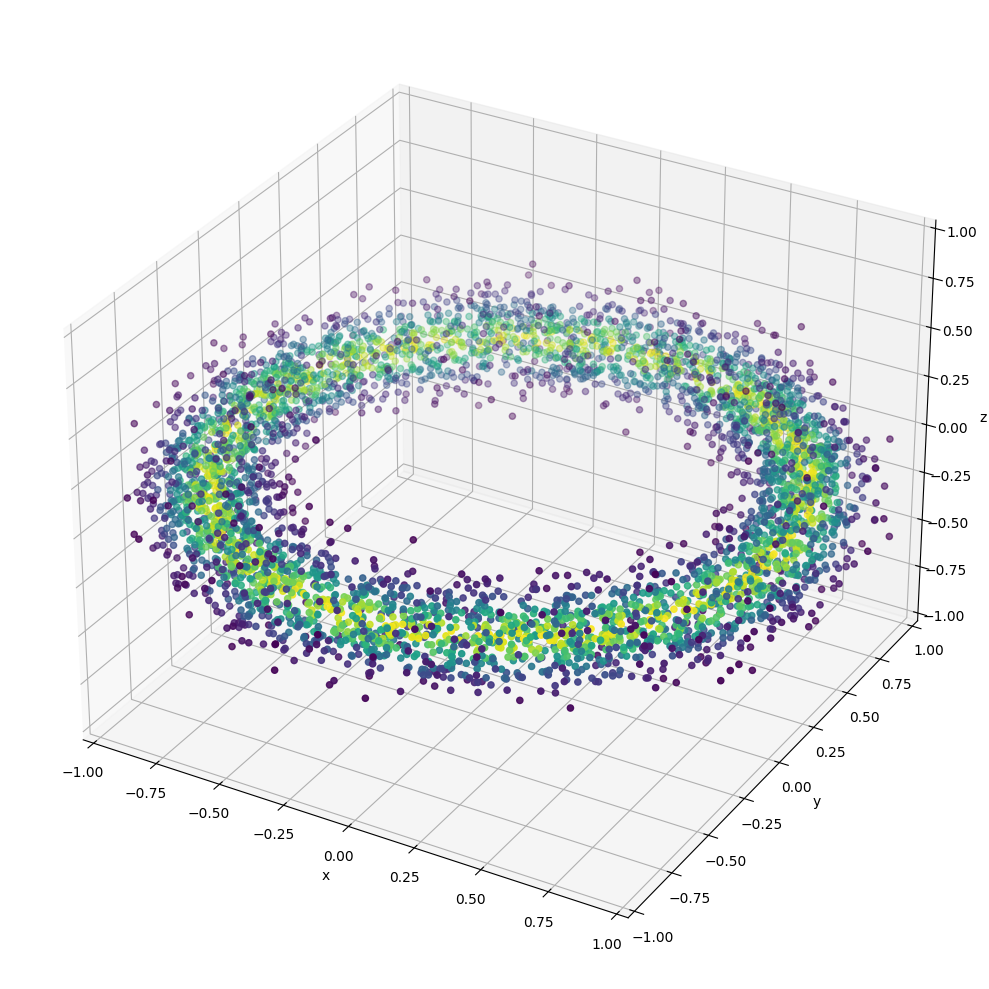

In [8]:
pnt_colors = exp(probs - probs.max()) # color the points by probability

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
L = 1.0
ax.set_xlim([-L, L]); ax.set_ylim([-L, L]); ax.set_zlim([-L, L])
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.scatter(x_vals, y_vals, z_vals, c=pnt_colors)
plt.tight_layout()
plt.show()

We can plot all the possible 1D and 2D marginal distirbutions of the posterior (or a sub-set of them) using the ``matrix_plot()`` method:

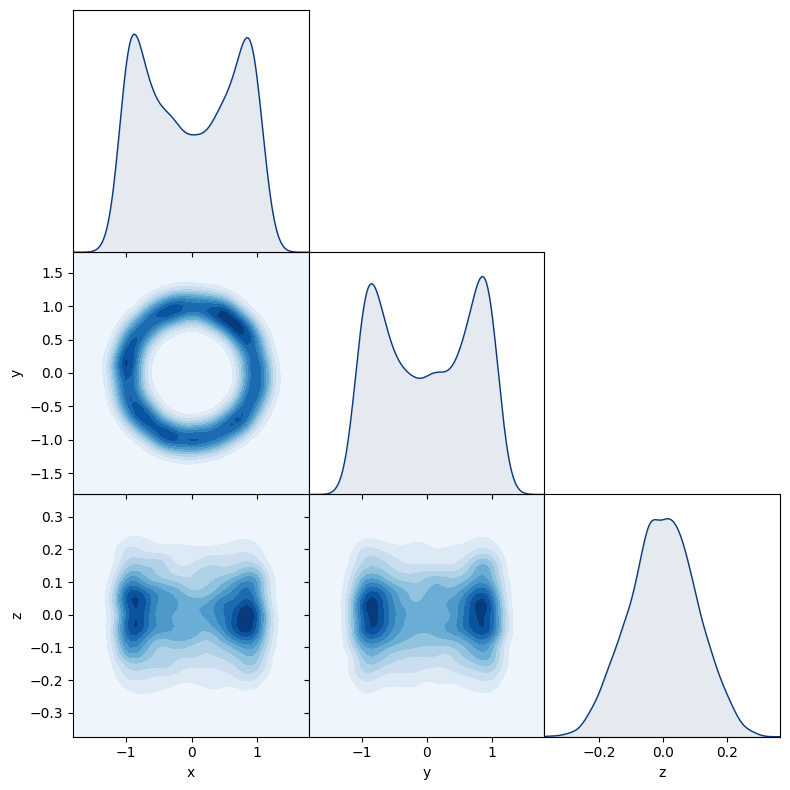

In [7]:
chain.matrix_plot(labels = ['x','y','z'], burn=burn)